In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error
# Set a random seed for reproducibility
torch.manual_seed(42)

In [13]:
from differential_model import *
from generate_data import *
from physical_model import *
from plot import *

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")
device = torch.device("cpu")

GPU: NVIDIA GeForce GTX 1650 Ti


In [15]:
# Define parameters for the structural dynamics problem
ndof = 5  # Number of degrees of freedom
kvec = [95, 98, 100, 104, 97]
cvec = [0.18, 0.22, 0.24, 0.18, 0.19]
mvec = [1, 1, 1, 0.8, 0.8]

# Create an assembly matrix 'onemat'
onemat = np.array([[1, -1], [-1, 1]])

# Initialize the assembly matrix for each degree of freedom
assembly_mat = [np.zeros((ndof, ndof)) for _ in range(ndof)]
assembly_mat[0][0, 0] = 1

# Initialize Mass, Stiffness, and Damping matrices
Mass = np.diag(mvec)
Stif = np.zeros((ndof, ndof))
Damp = np.zeros((ndof, ndof))

# Assemble Stiffness and Damping matrices
for i in range(ndof):
    if i != 0:
        assembly_mat[i] = np.zeros((ndof, ndof))
        assembly_mat[i][i-1:i+1, i-1:i+1] = onemat
    Stif += kvec[i] * assembly_mat[i]
    Damp += cvec[i] * assembly_mat[i]

# Now, 'Stif' and 'Damp' matrices are assembled based on the assembly_mat and provided parameters

fs = 50
Tf = 10
tspan = torch.arange(0, Tf, 1/fs)
nt = fs * Tf

In [16]:
# Initialize the Spring_Model on the GPU
spring_model_gt = NonLinearDynamicsModel(Mass, Stif, Damp, fs, device, k3vec = [10000, 0, 0, 5000, 0], c2vec = [0, 0, 0, 0, 0])
simulator = LinearDynamicsModel(Mass, Stif, Damp, fs, device)

Current State: 1
A Shape: torch.Size([10, 10])
B Shape: torch.Size([10, 5])
A_k3 Shape: torch.Size([10, 10])
A_c2 Shape: torch.Size([10, 10])


In [17]:
# Create a neural network model
model1 = NeuralNet(11, [16, 32, 64, 32, 16], 10, nn.ReLU(), device)
model1.load_state_dict(torch.load('non_linear_5_dof_model_parameters.pth'))
model2 = NeuralNet(11, [16, 32, 64, 32, 16], 5, nn.ReLU(), device)
model2.load_state_dict(torch.load('non_linear_5_dof_model_epsilon_parameters_m1.pth'))


<All keys matched successfully>

In [18]:
# Assuming you have the ground truth and simulated data
sig_u_test = [5,7]  # Adjust the range and number of points as needed
data_gt_test = torch.zeros(nt, len(sig_u_test), 10)
data_simulated_test = torch.zeros(nt, len(sig_u_test), 10)
data_simulated_NN_test = torch.zeros(nt, len(sig_u_test), 10)
u_data_test = torch.zeros(nt, len(sig_u_test), 5)
data_simulated_NN_Epsilon_test = torch.zeros(nt, len(sig_u_test), 10)

# Arrays to store metrics
r2_simulated=torch.zeros(len(sig_u_test), 10)
RMSE_simulated =torch.zeros(len(sig_u_test), 10)
L2_simulated =torch.zeros(len(sig_u_test), 10)

r2_simulated_NN=torch.zeros(len(sig_u_test), 10)
RMSE_simulated_NN=torch.zeros(len(sig_u_test), 10)
L2_simulated_NN =torch.zeros(len(sig_u_test), 10)

r2_simulated_NN_epsilon=torch.zeros(len(sig_u_test), 10)
RMSE_simulated_NN_epsilon=torch.zeros(len(sig_u_test), 10)
L2_simulated_NN_epsilon =torch.zeros(len(sig_u_test), 10)

for i in range(len(sig_u_test)):
    u = generate_u(sig_u_test[i], nt, fs, device)
    u_vec = torch.zeros(nt, 5).to(device)
    u_vec[:, 0] = u
    data_gt_test[:, i, :] = generate_date(spring_model_gt, u_vec).T
    data_simulated_test[:, i, :] = generate_date(simulator, u_vec).T
    u_data_test[:, i, :] = u_vec

    yi = data_simulated_NN_test[0, :].T
    for m in range(nt - 1):
        u_m = u_data_test[m , :].T # torch.Size([1, 5])
        yi = simulator.step(yi, u_m)
        input = torch.cat([u_m[0:1, :], yi], axis=0).T  # Concatenate k and yi.T
        dy_i = model1(input).T # torch.Size([2, 5])
        yi = yi + dy_i
        data_simulated_NN_test[m + 1, :] = yi.T


    yi_epsilon = data_simulated_NN_test[0, :].T
    for m in range(nt - 1):
        u_m_epsilon= u_data_test[m , :].T # torch.Size([1, 5])
        # yi_epsilon = simulator.step(yi_epsilon, u_m)
        input = torch.cat([u_m[0:1, :], yi_epsilon], axis=0).T  # Concatenate k and yi.T
        epsilon = model2(input).T # torch.Size([2, 5])
        u_m_epsilon  = u_m_epsilon + epsilon
        yi_epsilon = simulator.step(yi_epsilon,u_m_epsilon)
        data_simulated_NN_Epsilon_test[m + 1, :] = yi_epsilon.T


    gt=data_gt_test[:, i, :].cpu().numpy()
    simulated=data_simulated_test[:, i, :].cpu().detach().numpy()
    simulated_NN = data_simulated_NN_test[:, i, :].cpu().detach().numpy()
    simulated_NN_epsilon= data_simulated_NN_Epsilon_test[:, i, :].cpu().detach().numpy()


    # Calculate R2 score
     # Calculate R2 score
    for j in range(10):
        r2_simulated[i][j]= torch.tensor(r2_score(gt[:, j], simulated[:, j]), dtype=torch.float32)
        r2_simulated_NN[i][j]= torch.tensor(r2_score(gt[:, j], simulated_NN[:, j]), dtype=torch.float32)
        r2_simulated_NN_epsilon[i][j]=torch.tensor(r2_score(gt[:, j], simulated_NN_epsilon[:, j]), dtype=torch.float32)

    # Calculate RMSE (Root Mean Squared Error)
        RMSE_simulated[i][j] = torch.tensor(mean_squared_error(gt[:, j], simulated[:, j], squared=False), dtype=torch.float32)
        RMSE_simulated_NN[i][j]= torch.tensor(mean_squared_error(gt[:, j], simulated_NN[:, j], squared=False), dtype=torch.float32)
        RMSE_simulated_NN_epsilon[i][j] = torch.tensor(mean_squared_error(gt[:, j], simulated_NN_epsilon[:, j], squared=False), dtype=torch.float32)

    # Calculate L2 loss
        L2_simulated[i][j]= torch.tensor(((gt[:, j] - simulated[:, j]) ** 2).sum(), dtype=torch.float32)
        L2_simulated_NN[i][j] = torch.tensor(((gt[:, j] - simulated_NN[:, j]) ** 2).sum(), dtype=torch.float32)
        L2_simulated_NN_epsilon[i][j] = torch.tensor(((gt[:, j] - simulated_NN_epsilon[:, j]) ** 2).sum(), dtype=torch.float32)


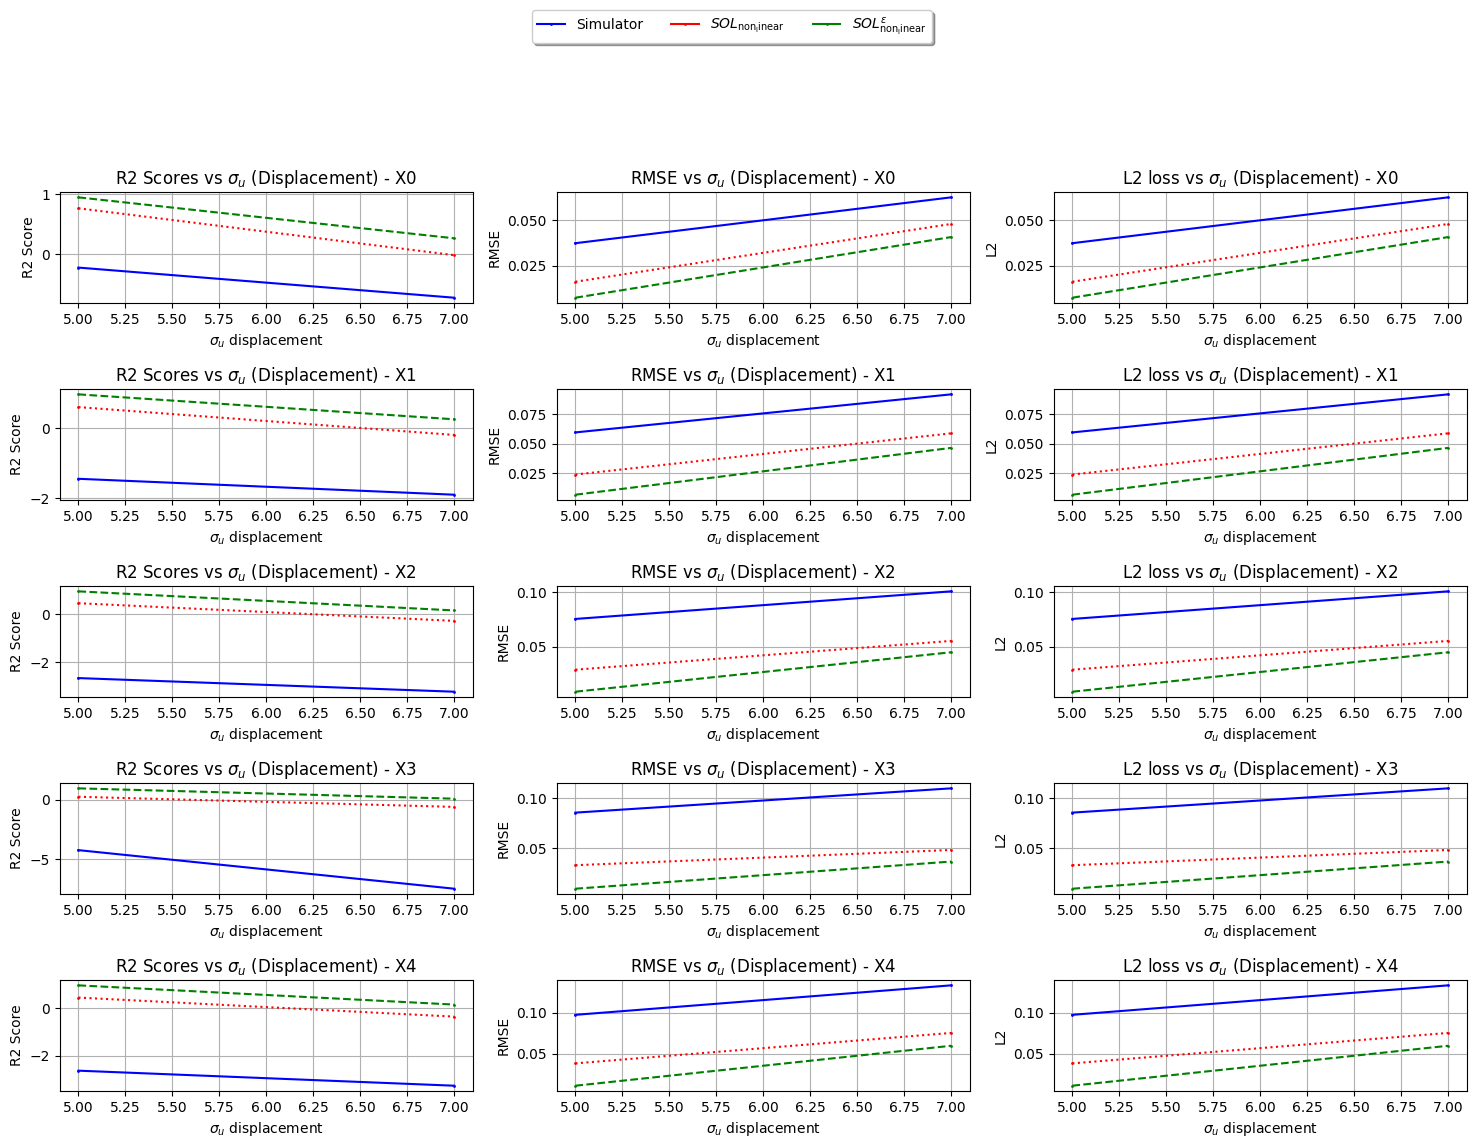

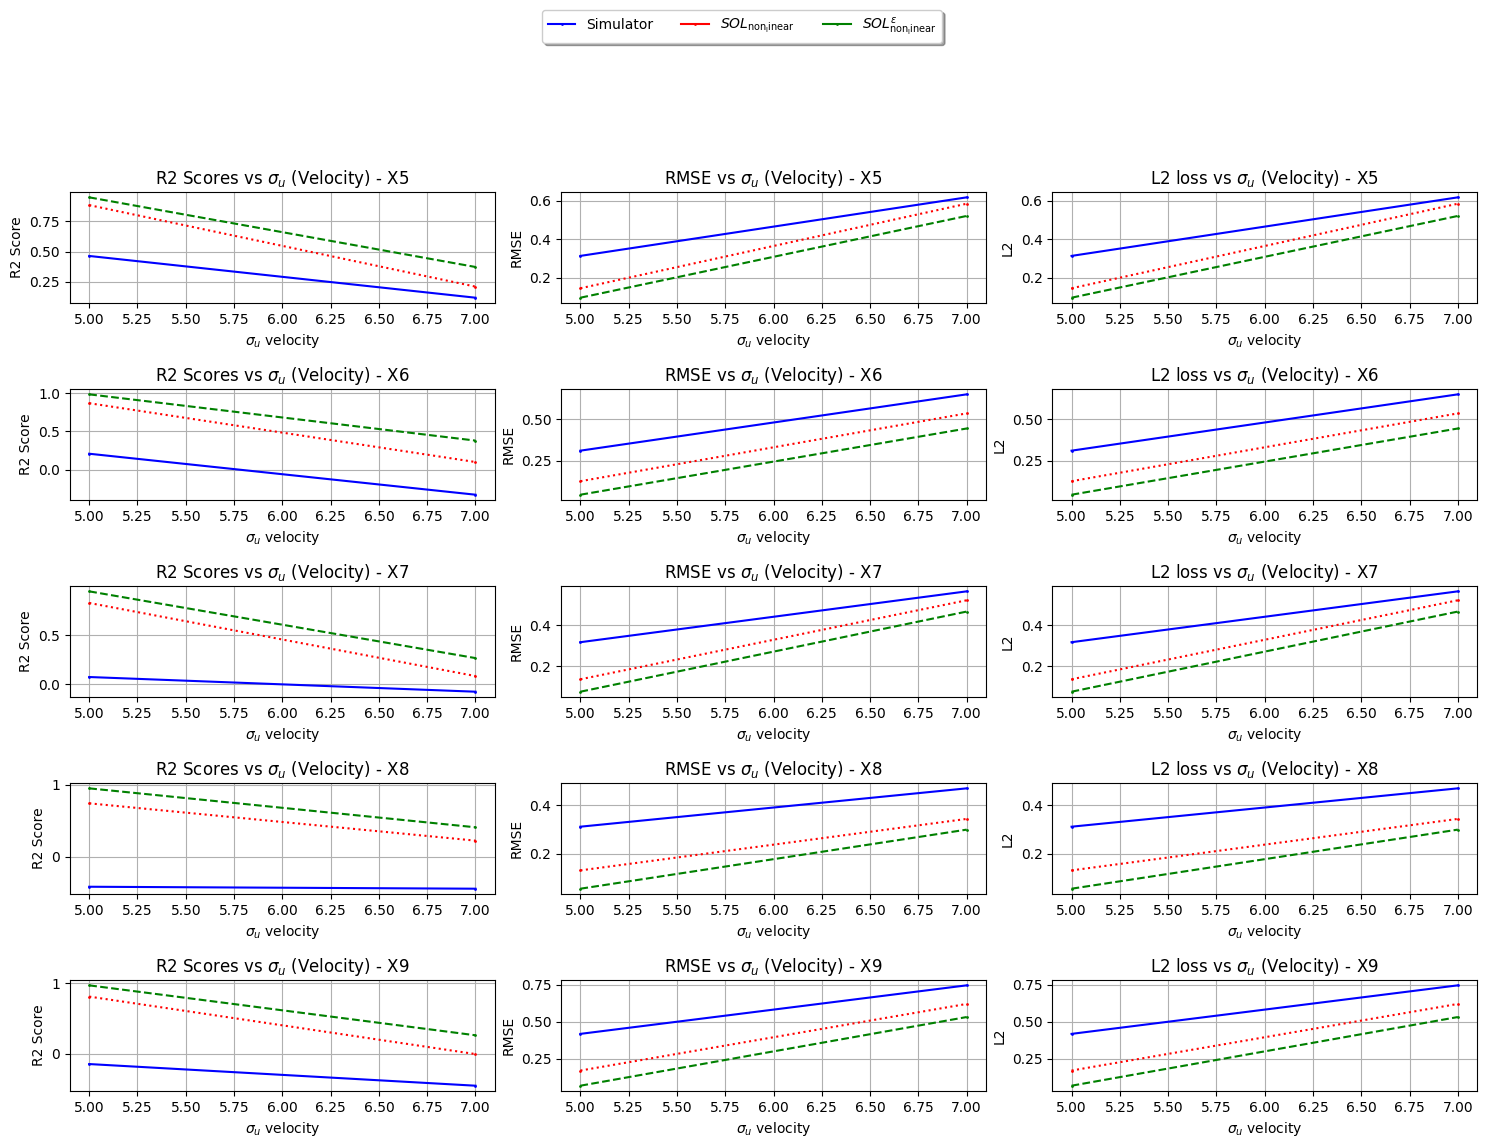

In [19]:
import matplotlib.pyplot as plt

# Set a distinct color cycle for different labels
colors = ['b', 'g', 'r', 'c', 'm']

# Set smaller marker size
marker_size = 1

# Set a larger figure size suitable for a report
report_figure_size = (15, 10)

# Rename sig_u_test to sigma_u_test
sigma_u_test = sig_u_test

# Plotting the R2, RMSE, L2 loss against sigma_u_test for displacement
plt.figure(figsize=report_figure_size)

# R2 Score (Displacement)
for j in range(5):
    plt.subplot(5, 3, j*3 + 1)
    plt.plot(sigma_u_test, r2_simulated[:, j], marker='o', markersize=marker_size, label='', color=colors[0])
    plt.plot(sigma_u_test, r2_simulated_NN[:, j], marker='o', markersize=marker_size, label='', linestyle='--', color=colors[1])
    plt.plot(sigma_u_test, r2_simulated_NN_epsilon[:, j], marker='o', markersize=marker_size, label='', linestyle=':', color=colors[2])
    plt.title(f'R2 Scores vs $\\sigma_u$ (Displacement) - X{j}')
    plt.xlabel('$\\sigma_u$ displacement')
    plt.ylabel('R2 Score')
    plt.grid(True)

    plt.subplot(5, 3, j*3 + 2)
    plt.plot(sigma_u_test, RMSE_simulated[:, j], marker='o', markersize=marker_size, label='', color=colors[0])
    plt.plot(sigma_u_test, RMSE_simulated_NN[:, j], marker='o', markersize=marker_size, label='', linestyle='--', color=colors[1])
    plt.plot(sigma_u_test, RMSE_simulated_NN_epsilon[:, j], marker='o', markersize=marker_size, label='', linestyle=':', color=colors[2])
    plt.title(f'RMSE vs $\\sigma_u$ (Displacement) - X{j}')
    plt.xlabel('$\\sigma_u$ displacement')
    plt.ylabel('RMSE')
    plt.grid(True)

    plt.subplot(5, 3, j*3 + 3)
    plt.plot(sigma_u_test, RMSE_simulated[:, j], marker='o', markersize=marker_size, label='', color=colors[0])
    plt.plot(sigma_u_test, RMSE_simulated_NN[:, j], marker='o', markersize=marker_size, label='', linestyle='--', color=colors[1])
    plt.plot(sigma_u_test, RMSE_simulated_NN_epsilon[:, j], marker='o', markersize=marker_size, label='', linestyle=':', color=colors[2])
    plt.title(f'L2 loss vs $\\sigma_u$ (Displacement) - X{j}')
    plt.xlabel('$\\sigma_u$ displacement')
    plt.ylabel('L2')
    plt.grid(True)

# Add a single legend box mentioning labels for the three different colors
# Add a single legend box mentioning labels for the three different colors
plt.figlegend(handles=[plt.Line2D([0], [0], marker='o', color='b', markerfacecolor='b', markersize=marker_size),
                      plt.Line2D([0], [0], marker='o', color='r', markerfacecolor='g', markersize=marker_size),
                      plt.Line2D([0], [0], marker='o', color='g', markerfacecolor='r', markersize=marker_size)],
              labels = ['Simulator', r'$SOL_{\mathrm{non_linear}}$', r'$SOL_{\mathrm{non_linear}}^{\epsilon}$'],
              loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

# Remove the previous plt.figtext line
# plt.figtext(0.92, 0.5, 'Blue: R2 Simulated\nGreen: R2 Simulated NN\nRed: R2 Simulated NN Epsilon',
#             fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


# Plotting the R2, RMSE, L2 loss against sigma_u_test for velocity
plt.figure(figsize=report_figure_size)

# R2 Score (Velocity)
for j in range(5, 10):
    plt.subplot(5, 3, (j-5)*3 + 1)
    plt.plot(sigma_u_test, r2_simulated[:, j], marker='o', markersize=marker_size, label='', color=colors[0])
    plt.plot(sigma_u_test, r2_simulated_NN[:, j], marker='o', markersize=marker_size, label='', linestyle='--', color=colors[1])
    plt.plot(sigma_u_test, r2_simulated_NN_epsilon[:, j], marker='o', markersize=marker_size, label='', linestyle=':', color=colors[2])
    plt.title(f'R2 Scores vs $\\sigma_u$ (Velocity) - X{j}')
    plt.xlabel('$\\sigma_u$ velocity')
    plt.ylabel('R2 Score')
    plt.grid(True)

    plt.subplot(5, 3, (j-5)*3 + 2)
    plt.plot(sigma_u_test, RMSE_simulated[:, j], marker='o', markersize=marker_size, label='', color=colors[0])
    plt.plot(sigma_u_test, RMSE_simulated_NN[:, j], marker='o', markersize=marker_size, label='', linestyle='--', color=colors[1])
    plt.plot(sigma_u_test, RMSE_simulated_NN_epsilon[:, j], marker='o', markersize=marker_size, label='', linestyle=':', color=colors[2])
    plt.title(f'RMSE vs $\\sigma_u$ (Velocity) - X{j}')
    plt.xlabel('$\\sigma_u$ velocity')
    plt.ylabel('RMSE')
    plt.grid(True)

    plt.subplot(5, 3, (j-5)*3 + 3)
    plt.plot(sigma_u_test, RMSE_simulated[:, j], marker='o', markersize=marker_size, label='', color=colors[0])
    plt.plot(sigma_u_test, RMSE_simulated_NN[:, j], marker='o', markersize=marker_size, label='', linestyle='--', color=colors[1])
    plt.plot(sigma_u_test, RMSE_simulated_NN_epsilon[:, j], marker='o', markersize=marker_size, label='', linestyle=':', color=colors[2])
    plt.title(f'L2 loss vs $\\sigma_u$ (Velocity) - X{j}')
    plt.xlabel('$\\sigma_u$ velocity')
    plt.ylabel('L2')
    plt.grid(True)
plt.figlegend(handles=[plt.Line2D([0], [0], marker='o', color='b', markerfacecolor='b', markersize=marker_size),
                      plt.Line2D([0], [0], marker='o', color='r', markerfacecolor='g', markersize=marker_size),
                      plt.Line2D([0], [0], marker='o', color='g', markerfacecolor='r', markersize=marker_size)],
              labels = ['Simulator', r'$SOL_{\mathrm{non_linear}}$', r'$SOL_{\mathrm{non_linear}}^{\epsilon}$'],
              loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

# Add a single legend box mentioning labels for the three different colors
# plt.figtext(0.92, 0.5, 'Blue: R2 Simulated\nGreen: R2 Simulated NN\nRed: R2 Simulated NN Epsilon',
#             fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


In [20]:
print(r2_simulated.size())

torch.Size([2, 10])


In [21]:
initial_error_test = torch.mean((data_gt_test -data_simulated_test) ** 2)
final_error_test = torch.mean((data_gt_test -data_simulated_NN_test) ** 2)
final_epsilon_error_test= torch.mean((data_gt_test - data_simulated_NN_Epsilon_test) ** 2)
initial_error_test, final_error_test, final_epsilon_error_test

(tensor(0.1275),
 tensor(0.0548, grad_fn=<MeanBackward0>),
 tensor(0.0764, grad_fn=<MeanBackward0>))

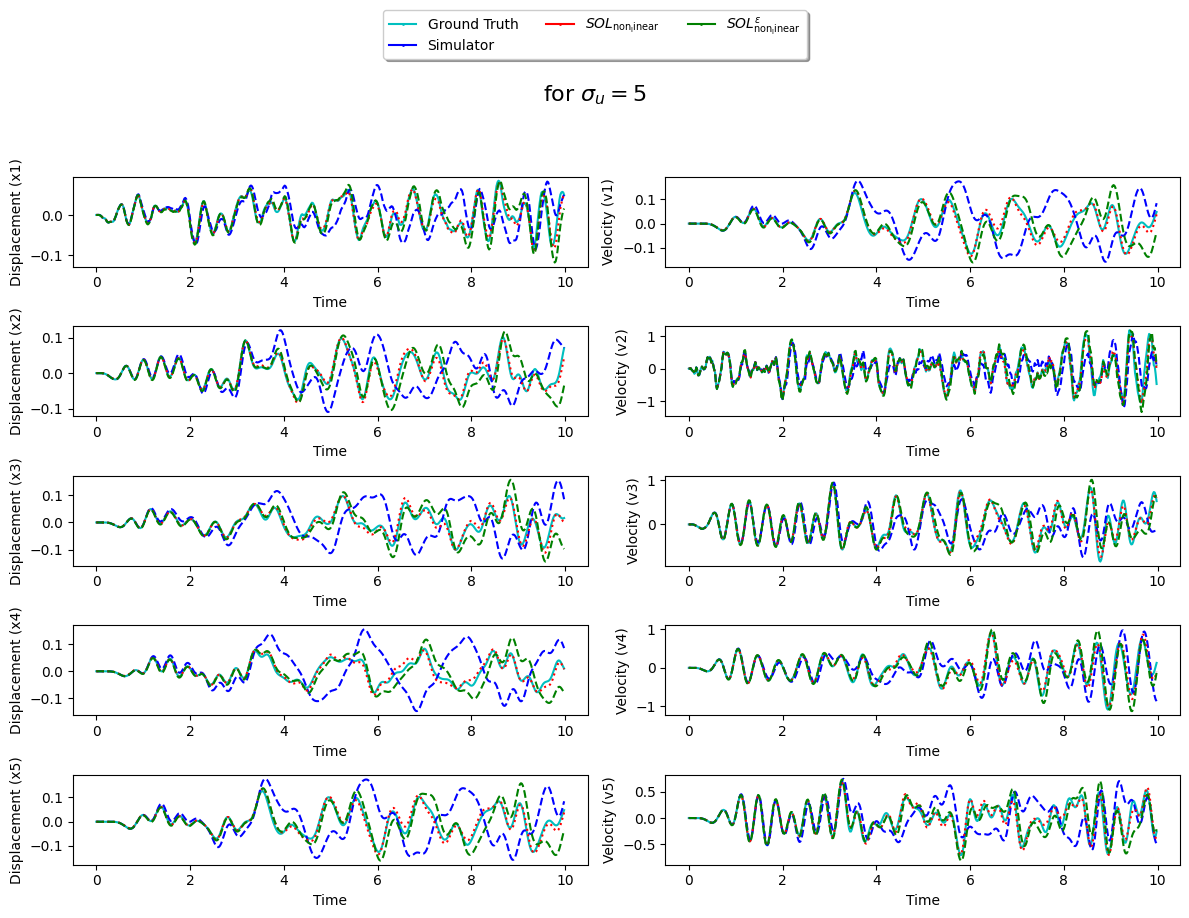

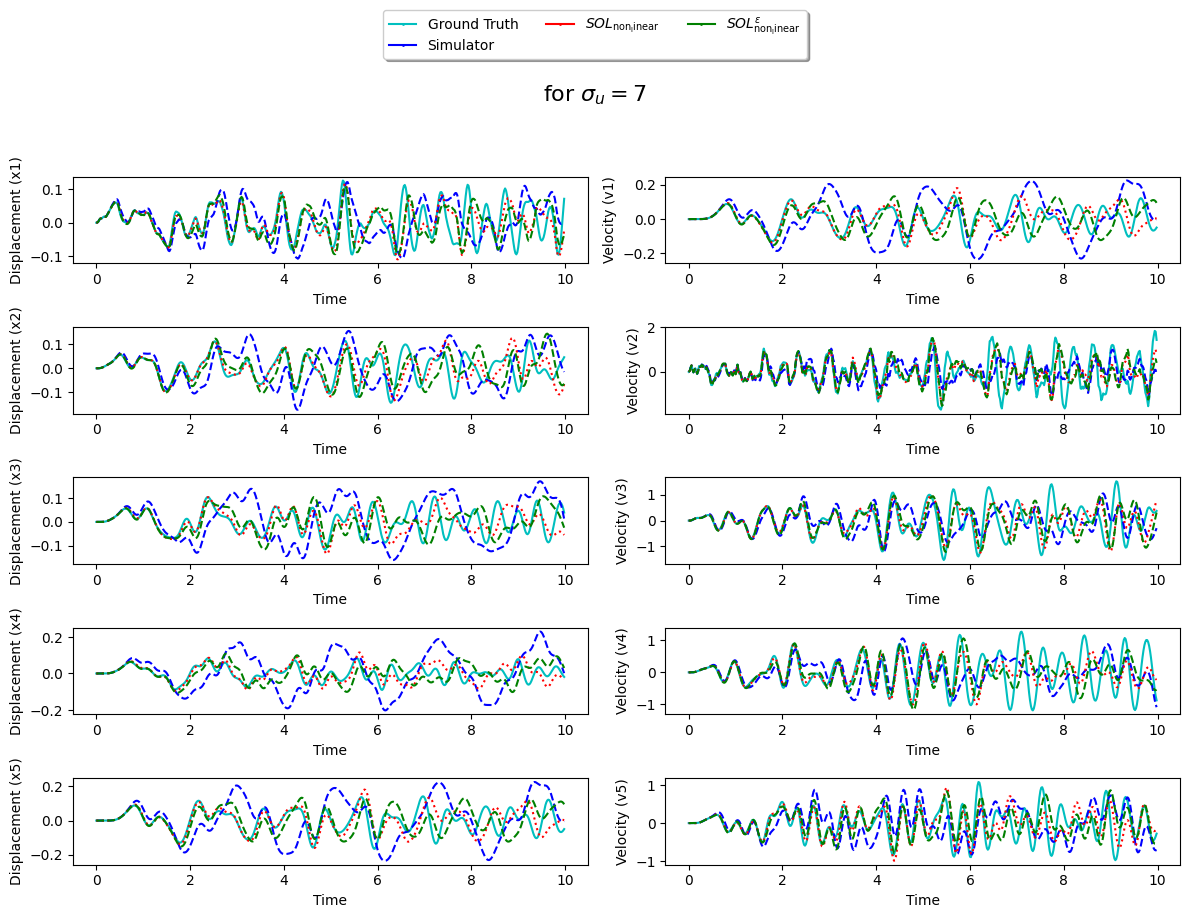

In [22]:
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Function to adjust the overall figure size and create a box legend
def adjust_and_legend():
    plt.figure(figsize=(12, 8))

# Plotting
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u_test)):
    adjust_and_legend()

    # Plotting for each degree of freedom
    for j in range(ndof):
        plt.subplot(ndof, 2, 2*j+1)  # For displacement (x)
        plt.plot(time_values, data_gt_test[:, i, j], label=f'Ground Truth - x{ j + 1 }', linestyle='-', color='c')
        plt.plot(time_values, data_simulated_test[:, i, j], label=f'Simulated - x{ j + 1 }', linestyle='--', color='b')
        plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, j], label=f'NN Simulated - x{ j + 1 }', linestyle=':', color='r')
        plt.plot(time_values, data_simulated_NN_Epsilon_test.detach().numpy()[:, i, j], label=f'NN Epsilon Simulated - x{ j + 1 }', linestyle='--', color='g')
        plt.xlabel('Time')
        plt.ylabel(f'Displacement (x{ j + 1 })')

    for j in range(ndof):
        plt.subplot(ndof, 2, 2*j+2)  # For velocity (v)
        plt.plot(time_values, data_gt_test[:, i, j + 4], label=f'Ground Truth - v{ j + 1 }', linestyle='-', color='c')
        plt.plot(time_values, data_simulated_test[:, i, j + 4], label=f'Simulated - v{ j + 1 }', linestyle='--', color='b')
        plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, j + 4], label=f'NN Simulated - v{ j + 1 }', linestyle=':', color='r')
        plt.plot(time_values, data_simulated_NN_Epsilon_test.detach().numpy()[:, i, j + 4], label=f'NN Epsilon Simulated - v{ j + 1 }', linestyle='--', color='g')

        plt.xlabel('Time')
        plt.ylabel(f'Velocity (v{ j + 1 })')

    # Manually add legend entries for the box legend
# Manually add legend entries for the box legend
    plt.figlegend(handles=[plt.Line2D([0], [0], marker='o', color='c', markerfacecolor='c', markersize=marker_size),
                       plt.Line2D([0], [0], marker='o', color='b', markerfacecolor='b', markersize=marker_size),
                       plt.Line2D([0], [0], marker='o', color='r', markerfacecolor='r', markersize=marker_size),
                       plt.Line2D([0], [0], marker='o', color='g', markerfacecolor='g', markersize=marker_size)],
              labels = ['Ground Truth','Simulator', r'$SOL_{\mathrm{non_linear}}$', r'$SOL_{\mathrm{non_linear}}^{\epsilon}$'],
              loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)
    
    plt.suptitle(f'for $\\sigma_{{u}}={sig_u_test[i]}$', y=1.05, fontsize=16)

    plt.tight_layout(rect=[0, 0.1, 1, 1.1])

    plt.tight_layout()
    plt.show()
